# Fresnel Propagation with POPPY 

`poppy` now includes support for Fresnel propagation. This notebook demonstrates some of that functionality.

## Basics: FresnelWavefront and propagation through free space

The API has been kept as similar as possible to the original Fraunhofer mode of `poppy`. There are `FresnelWavefront` and `FresnelOpticalSystem` classes, which can be used for the most part similar to the `Wavefront` and `OpticalSystem` classes. There are a few key differences however. 

First and foremost, the user must specify the physical separation between optics and must explicitly include lenses to refocus beams, rather than simply letting that automatically be handled under the Fraunhofer assumptions. 
A second notable difference is that the `Fresnel` classes make use of the `astropy.Quantities` framework for units conversion, particularly for propagation distances. 

To support Fresnel propagation, under the hood `poppy` makes use of several different propagation algorithms, and `FresnelWavefront`s may be represented on circular as well as planar surfaces. The approach is generally similar to that taken by John Krist's package PROPER (available from http://proper-library.sourceforge.net), for any users who are familiar with that. 

### Example 1: Edge ringing after a circular aperture

Let us begin by demonstrating the propagation of a plane wave through an aperture, and examine the resulting intensity pattern after some distance through free space. 

In [1]:
%pylab inline
import poppy
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


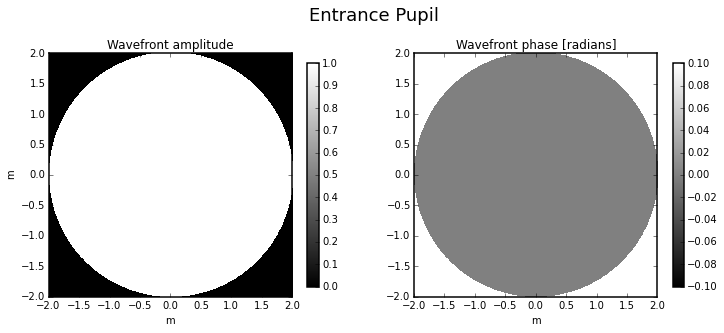

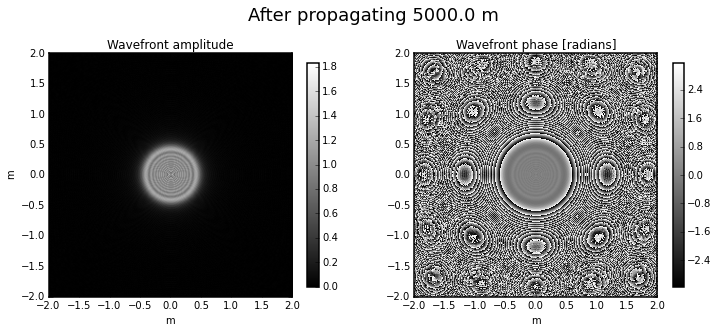

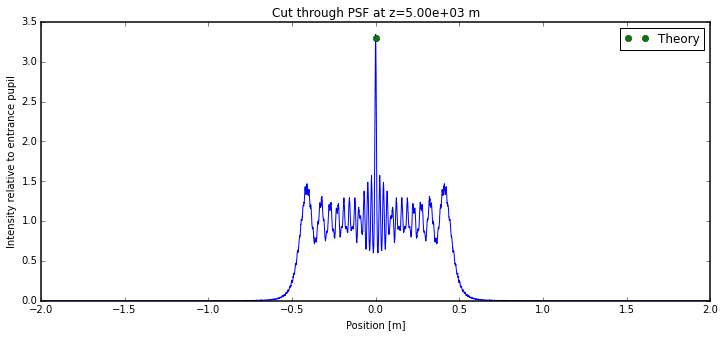

In [2]:
display=True
npix = 1024#~512 is minimum to accurately recover the central diffraction spike
gw = poppy.FresnelWavefront(0.5*u.m,wavelength=2200e-9,npix=npix,oversample=4)
gw *= poppy.CircularAperture(radius=0.5,oversample=gw.oversample)

if display:
    plt.figure(figsize=(12,5))
    gw.display('both',colorbar=True)
    plt.suptitle("Entrance Pupil", fontsize=18)

z = 5e3*u.m

gw.propagate_fresnel(z)

if display:
    plt.figure(figsize=(12,5))
    gw.display('both',colorbar=True)
    plt.suptitle("After propagating {}".format(z), fontsize=18)
    
    plt.figure(figsize=(12,5))
    y, x = gw.coordinates()
    plt.plot(x[gw.intensity.shape[1]/2,:], gw.intensity[gw.intensity.shape[1]/2,:])
    plt.title("Cut through PSF at z={:0.2e}".format(z))
    plt.xlabel('Position [m]')
    plt.ylabel('Intensity relative to entrance pupil')
    
    plt.plot([0], [3.30], 'o', label='Theory')
    plt.legend(loc='upper right')

We see the expected ringing from the aperture edges. The peak intensity agrees well with the expected theoretical value. Note that, as with any numerical calculation, the degree of accuracy achieved depends on the details of the wavefront sampling and so forth. Here we chose to perform this calculation at moderately high resolution (1024 pixels across the illuminated pupil, times a sampling factor of 4, therefore 4096x4096 arrays are used to represent the wavefront.)


### Example 2: Divergence of a Gaussian Beam near the Beam Waist

Beams with Gaussian intensity patterns are often encountered, for instance in laser physics or as a close approximation to the exit pupil of a single-mode optical fiber. Gaussian beams have particularly simple propagation, which can be described at all points in space based on a few parameters of the so-called beam waist, for instance the wavelength $\lambda$ and the radius $w_0$ and position $z$ of the waist. 

The Fresnel propagation code makes extensive use internally of Gaussian beam parameters for representing the convergence of spherical waves. Here we demonstrate that the `FresnelWavefront` code can reproduce the well-known variation in beam radius of curvature $R_c$ and beam width $w$ as a function of the propagation distance $z$. These are normalized to the Rayleigh distance $z_R$.

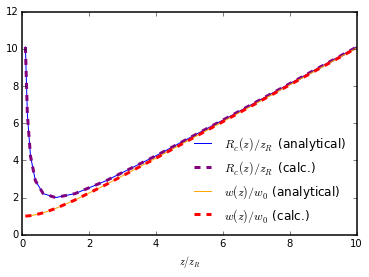

In [39]:
# setup an initial Gaussian beam in an aperture. 

ap = poppy.CircularAperture(radius=1)
wf0 = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=1e-6)

z_rayleigh = wf0.z_R    # the Rayleigh distance

z = z_rayleigh * np.logspace(-1,1,num=11)

calc_rz = []
calc_wz = []
for zi in z:
    #setup entrance wave
    wf = poppy.FresnelWavefront(1*u.m, wavelength=1e-6)
    wf.propagate_fresnel(zi)
    
    # calculate the beam radius and curvature vs z
    calc_rz.append( (wf.R_c()/z_rayleigh).value)
    calc_wz.append( (wf.spot_radius()/wf.w_0).value)
        
# Compare to the analytic solution for Gaussian beam propagation
zdzr = z/z_rayleigh
rz = (z**2 + z_rayleigh**2)/z
wz = wf0.w_0*np.sqrt(1+zdzr**2)

plt.plot(zdzr, rz/z_rayleigh, label="$R_c(z)/z_R$ (analytical)", color='blue')
plt.plot(zdzr, calc_rz, ls='dashed', linewidth=3, color='purple', label="$R_c(z)/z_R$ (calc.)")
plt.plot(zdzr, wz/wf.w_0, label="$w(z)/w_0$ (analytical)", color='orange')
plt.plot(zdzr, calc_wz, ls='dashed', linewidth=3, color='red', label="$w(z)/w_0$ (calc.)")
plt.xlabel("$z/z_R$")
plt.legend(loc='lower right', frameon=False);


The results are as expected.

## Adding Lenses

To add here some example of a simple system with a lens. 

Why is the class called a `GaussianLens` anyway? What's Gaussian about it? 

## FresnelOpticalSystem

Just like the `OpticalSystem` serves as a high-level container for `OpticalElement`s in Fraunhofer propagation, the `FresnelOpticalSystem` serves the same purpose in Fresnel propagation. 

Note that when adding `OpticalElement`s to the `FresnelOpticalSystem`, you use an `add_optic` function and must specify a physical distance separating that optic from the previous optic. This replaces the `addImage` and `addPupil` methods used in Fraunhofer propagation.

The following example presents a simplified version of the Hubble Space Telescope.

The specific numeric values used for Hubble are taken from the HST example code in the PROPER manual by John Krist,
version 2.0a available from http://proper-library.sourceforge.net
This is not intended as a high-fidelity model of Hubble, and for instance this simplified the primary aperture obscuration, and neglects the specific conic constants of the optics including the infamous spherical aberration.


In [2]:
# HST example - Following example in PROPER Manual V2.0 page 49.
diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=512, beam_ratio=0.25)
m1 = poppy.GaussianLens(fl_pri, name='Primary')
m2 = poppy.GaussianLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=poppy.PlaneType.image), distance=d_sec_to_focus);

In [3]:
hst.describe()

	Entrance pupil diam:  2.4 m	npix: 512	Beam ratio:0.25
	Pupil plane: Circle, radius=1.20 m (Analytic)
	Pupil plane: Secondary Obscuration with 4 supports (Analytic)
	Lens: Primary, with focal length 5.52085 m
	Propagation distance:  4.907028205 m
	Lens: Secondary, with focal length -0.6790325 m
	Propagation distance:  6.3919974 m
	Image plane: -empty- (Analytic)


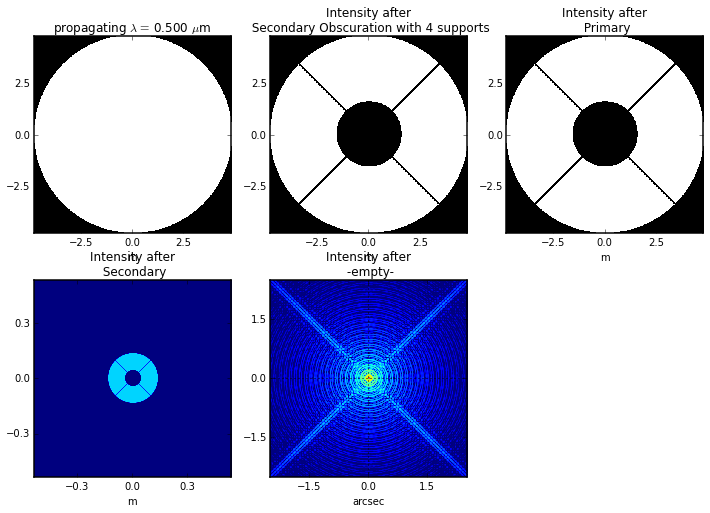

In [4]:
plt.figure(figsize=(12,8))
psf, waves = hst.calcPSF(wavelength=0.5e-6, display_intermediates=True, return_intermediates=True)

The output files are format-compatible with other files produced by `poppy`, and can be used interchangably in the various display and measurement routines.

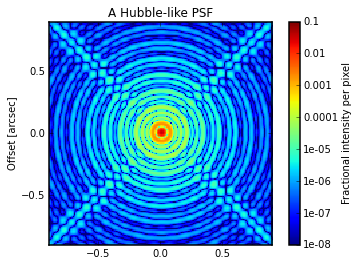

In [5]:
poppy.display_PSF(psf,imagecrop=1.8)
plt.title('A Hubble-like PSF')
plt.ylabel("Offset [arcsec]");

####A caution on coordinates:


One subtle point to be aware of is a small but important difference in image centering. The Fraunhofer code is set up to by default always place the PSF center precisely in the middle of the array, so for instance in a 1024x1024 array the PSF has its (0,0) origin centered on the crosshairs between pixels [512,512] and [513,513]. In contrast the output of the Fresnel code has the origin (0,0) centered on an integer pixel, which would be [512,512] in this example. This behavior results from the coordinate conventions of the FFT used in the Fresnel propagation. The Fraunhofer code uses a more flexible MFT and if necessary can be adjusted to have its output align with what the Fresnel code does. 

#### Wait, how did it just automatically convert into angular units?

The PSF above is shown in angular units of arcseconds, just like PSFs from `OpticalSystem`. But the Fresnel propagation works in units of meters. In order to convert automatically between the two coordinate systems, Fresnel propagation tracks the focal length of the beam as it encountered powered optics. 

In [6]:
for w in waves:
    print("Focal length {} is {}".format(w.location, w.focal_length))

Focal length after Circle, radius=1.20 m is inf m
Focal length after Secondary Obscuration with 4 supports is inf m
Focal length after Primary is 5.52085 m
Focal length after Secondary is 57.4880547401 m
Focal length after -empty- is 57.4880547401 m


We can cross-check against the combined system focal length using the focal length of each mirror and their separation:

$$\frac{1}{f_{sys}} = \frac{1}{f_1} + \frac{1}{f_2} - \frac{d}{f_1  f_2}$$

In [7]:
print( "fl_sys = {}".format(1./(1./fl_pri + 1./fl_sec - d_pri_sec/(fl_pri*fl_sec))))

fl_sys = 57.4880547239 m


The answer above is slightly smaller than the generally reported value of 57.6 m.  Numerical experimentation shows that a very small adjustment to the separation to the two optics will resolve this discrepancy. Reducing the assumed primary-to-secondary distance by 0.0025% is sufficient. The reduction corresponds to about 100 microns difference in position out of a nearly 5 meter separation.  But as we noted above, this example case is a simplified version of Hubble and neglects the actual curvature of the mirrors. This is an acceptably good agreement within those limitations. 

Whenever an image plane optic is encountered in the propagation (i.e. any `OpticalElement` with its `.planetype` equal to `poppy.PlaneType.image`) then the `FresnelWavefront` will automatically return its coordinates in angular units, as expected by that optic. 

If desired you can toggle back and forth manually by setting the `angular_coordinates` attribute.

Here we show displaying the same PSF in physical units; it is only some tens of microns across. 

(-0.0007, 0.0007)

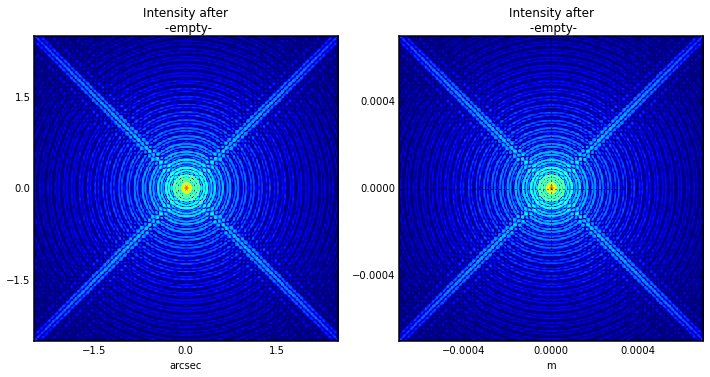

In [14]:
fig, axes=plt.subplots(ncols=2, figsize=(12,6))
waves[-1].angular_coordinates=True
waves[-1].display(ax=axes[0])

waves[-1].angular_coordinates=False
waves[-1].display(ax=axes[1]);
crop = 0.0007 # 0.7 mm
axes[1].set_xlim(-crop, crop)
axes[1].set_ylim(-crop, crop)